<a href="https://colab.research.google.com/github/arutraj/ML_Basics/blob/main/Rajavel_Sethupathi_DonorsChoose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import numpy as np
import pandas as pd
import zipfile
import os
import gdown
import math
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, hstack
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score


In [88]:
zip_url = "https://drive.google.com/uc?export=download&id=1KrnpfYRKVxGDnj-R2VZmNscEkR1zr2-4"

dataset_path = os.path.join("./dataset", "donors_choose")
zip_file_path = os.path.join(dataset_path, "donors_choose_dataset.zip")

if not os.path.exists(dataset_path):
  os.makedirs(dataset_path)

if not os.path.exists(zip_file_path):
   gdown.download(zip_url, zip_file_path, quiet=False)

with zipfile.ZipFile(zip_file_path ,"r") as zip_ref:
    zip_ref.extractall(dataset_path)

In [89]:
# read the files
dc_resources = pd.read_csv('/content/dataset/donors_choose/resources.csv')
dc_train_data = pd.read_csv('/content/dataset/donors_choose/train_data.csv')


In [90]:
dc_resources.head(3)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45


In [91]:
dc_train_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0


In [92]:
dc_resources.shape

(1541272, 4)

In [93]:
dc_train_data.shape

(109248, 17)

In [94]:
dc_train_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')

In [95]:
dc_resources.columns

Index(['id', 'description', 'quantity', 'price'], dtype='object')

In [96]:
dc_train_data.dtypes

Unnamed: 0                                       int64
id                                              object
teacher_id                                      object
teacher_prefix                                  object
school_state                                    object
project_submitted_datetime                      object
project_grade_category                          object
project_subject_categories                      object
project_subject_subcategories                   object
project_title                                   object
project_essay_1                                 object
project_essay_2                                 object
project_essay_3                                 object
project_essay_4                                 object
project_resource_summary                        object
teacher_number_of_previously_posted_projects     int64
project_is_approved                              int64
dtype: object

In [97]:
dc_resources.dtypes

id              object
description     object
quantity         int64
price          float64
dtype: object

In [98]:
dc_train_data.describe()

,Unnamed: 0,teacher_number_of_previously_posted_projects,project_is_approved
count,109248.000000,109248.000000,109248.000000
mean,91183.786568,11.153165,0.848583
std,52548.095272,27.777154,0.358456
min,0.000000,0.000000,0.000000
25%,45743.500000,0.000000,1.000000
50%,91253.500000,2.000000,1.000000
75%,136712.500000,9.000000,1.000000
max,182079.000000,451.000000,1.000000


**From observing the data, the following categorical features are noted -**

* project_grade_category
* project_subject_categories
* project_subject_subcategories
* teacher_prefix
* school_state

Making the values lowercase with underscore in place of spaces and  any special characters within the words  ..



## **Pre-processing project_grade_category**


---



In [99]:
dc_train_data['project_grade_category'].value_counts()

project_grade_category
Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: count, dtype: int64

In [100]:
# Removing all the spaces, replace the '-' with '_' and convert all the letters to small

dc_train_data['project_grade_category'] = dc_train_data['project_grade_category'].str.replace(' ','_').str.replace('-', '_')
dc_train_data['project_grade_category'] = dc_train_data['project_grade_category'].str.lower()
dc_train_data['project_grade_category'].value_counts()

project_grade_category
grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: count, dtype: int64

## **Pre-processing project_subject_categories**

In [101]:
dc_train_data['project_subject_categories'].value_counts().head()

project_subject_categories
Literacy & Language                    23655
Math & Science                         17072
Literacy & Language, Math & Science    14636
Health & Sports                        10177
Music & The Arts                        5180
Name: count, dtype: int64

In [102]:
# trim spaces, replace '&' with '_', and ',' with '_'
dc_train_data['project_subject_categories'] = dc_train_data['project_subject_categories'].str.replace(' The ','').str.replace(' ','').str.replace('&','_').str.replace(',','_')
dc_train_data['project_subject_categories'] = dc_train_data['project_subject_categories'].str.lower()
dc_train_data['project_subject_categories'].value_counts().head()

project_subject_categories
literacy_language                 23655
math_science                      17072
literacy_language_math_science    14636
health_sports                     10177
music_arts                         5180
Name: count, dtype: int64

## **Pre-processing project_subject_subcategories**

In [103]:
dc_train_data['project_subject_subcategories'].value_counts()

project_subject_subcategories
Literacy                             9486
Literacy, Mathematics                8325
Literature & Writing, Mathematics    5923
Literacy, Literature & Writing       5571
Mathematics                          5379
                                     ... 
Community Service, Gym & Fitness        1
Parent Involvement, Team Sports         1
Gym & Fitness, Social Sciences          1
Community Service, Music                1
Economics, Foreign Languages            1
Name: count, Length: 401, dtype: int64

In [104]:
# trim spaces,  replace '&' with '_', and ',' with '_'
dc_train_data['project_subject_subcategories'] = dc_train_data['project_subject_subcategories'].str.replace(' The ','').str.replace(' ','').str.replace('&','_').str.replace(',','_')
dc_train_data['project_subject_subcategories'] = dc_train_data['project_subject_subcategories'].str.lower()
dc_train_data['project_subject_subcategories'].value_counts()

project_subject_subcategories
literacy                          9486
literacy_mathematics              8325
literature_writing_mathematics    5923
literacy_literature_writing       5571
mathematics                       5379
                                  ... 
communityservice_gym_fitness         1
parentinvolvement_teamsports         1
gym_fitness_socialsciences           1
communityservice_music               1
economics_foreignlanguages           1
Name: count, Length: 401, dtype: int64

## **Preprocessing teacher_prefix**


In [105]:
dc_train_data['teacher_prefix'].value_counts()

teacher_prefix
Mrs.       57269
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: count, dtype: int64

In [106]:
# check for missing values and fill them with most frequently occuring element and that happens to be Mrs.
#
print(" Number of NaN missing values: ",dc_train_data['teacher_prefix'].isnull().values.sum())

dc_train_data['teacher_prefix']=dc_train_data['teacher_prefix'].fillna('Mrs.')

dc_train_data['teacher_prefix'].value_counts()

 Number of NaN missing values:  3


teacher_prefix
Mrs.       57272
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: count, dtype: int64

In [107]:
# make all characters lowercase and remove trailing dots

dc_train_data['teacher_prefix'] = dc_train_data['teacher_prefix'].str.replace('.','')
dc_train_data['teacher_prefix'] = dc_train_data['teacher_prefix'].str.lower()
dc_train_data['teacher_prefix'].value_counts()

teacher_prefix
mrs        57272
ms         38955
mr         10648
teacher     2360
dr            13
Name: count, dtype: int64

## **Preprocessing school_state**

In [108]:
dc_train_data['school_state'].value_counts().head()

school_state
CA    15388
TX     7396
NY     7318
FL     6185
NC     5091
Name: count, dtype: int64

In [109]:
# make all characters lowercase
dc_train_data['school_state'] = dc_train_data['school_state'].str.lower()
dc_train_data['school_state'].value_counts().head()

school_state
ca    15388
tx     7396
ny     7318
fl     6185
nc     5091
Name: count, dtype: int64

## **Preprocessing project_title**

In [110]:
# removing the words from the stop words list - ref - https://gist.github.com/sebleier/554280
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

# Expand language contractions ref - https://stackoverflow.com/a/47091490/4084039
# import regular expression (re) syntax
import re
def remove_lang_contraction(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase



In [111]:
dc_train_data['project_title']

0          Educational Support for English Learners at Home
1                     Wanted: Projector for Hungry Learners
2         Soccer Equipment for AWESOME Middle School Stu...
3                                    Techie Kindergarteners
4                                    Interactive Math Tools
                                ...                        
109243    Privacy Shields Help Promote Independent Thinking
109244                          Technology in Our Classroom
109245               2016/2017 Beginning of the Year Basics
109246              Flexible Seating in Inclusive Classroom
109247       Classroom Tech to Develop 21st Century Leaders
Name: project_title, Length: 109248, dtype: object

In [112]:
# printing the status bar with tqdm
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    for current_sentence in tqdm(text_data):

        # Expanding language contractions
        current_sentence = remove_lang_contraction(current_sentence)
        current_sentence = current_sentence.replace('\\r', ' ')
        current_sentence = current_sentence.replace('\\n', ' ')
        current_sentence = current_sentence.replace('\\"', ' ')
        current_sentence = re.sub('[^A-Za-z0-9]+', ' ', current_sentence)

        # Removing all stopwords
        current_sentence = ' '.join(e for e in current_sentence.split() if e.lower() not in stopwords)
        preprocessed_text.append(current_sentence.lower().strip())
    return preprocessed_text

In [113]:
preprocessed_titles_train = preprocess_text(dc_train_data['project_title'].values)

dc_train_data['project_title'] = preprocessed_titles_train

100%|██████████| 109248/109248 [00:04<00:00, 22726.03it/s]


In [114]:
# verification after processing
dc_train_data['project_title'].head(5)

0          educational support english learners home
1                   wanted projector hungry learners
2    soccer equipment awesome middle school students
3                             techie kindergarteners
4                             interactive math tools
Name: project_title, dtype: object

## **Preprocessing project_essay**

In [115]:
# the fields project_essay_1, project_essay_2, project_essay_3 and project_essay_4 are combined to project_essay
dc_train_data["project_essay"] = dc_train_data["project_essay_1"].map(str) +\
                        dc_train_data["project_essay_2"].map(str) + \
                        dc_train_data["project_essay_3"].map(str) + \
                        dc_train_data["project_essay_4"].map(str)

In [116]:
dc_train_data['project_essay'].head()

0    My students are English learners that are work...
1    Our students arrive to our school eager to lea...
2    \r\n\"True champions aren't always the ones th...
3    I work at a unique school filled with both ESL...
4    Our second grade classroom next year will be m...
Name: project_essay, dtype: object

In [117]:
preprocessed_dc_train_data = preprocess_text(dc_train_data['project_essay'].values)
dc_train_data['project_essay'] = preprocessed_dc_train_data

100%|██████████| 109248/109248 [01:30<00:00, 1204.78it/s]


In [118]:
# verification after processing
dc_train_data['project_essay'].head()

0    students english learners working english seco...
1    students arrive school eager learn polite gene...
2    true champions not always ones win guts mia ha...
3    work unique school filled esl english second l...
4    second grade classroom next year made around 2...
Name: project_essay, dtype: object

## **Preprocessing Numerical Values - price**

In [119]:
dc_resources.shape

(1541272, 4)

In [121]:
# first step:  summing all the price and quantity that belongs to the same project id, and reset index to make up for missing rows with this operation
#

dc_res_data = dc_resources.groupby('id').agg({'price': 'sum', 'quantity': 'sum'}).reset_index()
dc_res_data.head()

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21
2,p000003,298.97,4
3,p000004,1113.69,98
4,p000005,485.99,8


In [122]:
# second step - get the cost from price and quantity as a new column
dc_res_data['dc_res_cost'] = dc_res_data['price'] * dc_res_data['quantity']
dc_res_data.head()

,id,price,quantity,dc_res_cost
0,p000001,459.56,7,3216.92
1,p000002,515.89,21,10833.69
2,p000003,298.97,4,1195.88
3,p000004,1113.69,98,109141.62
4,p000005,485.99,8,3887.92


In [123]:
# keeping just the new cost column
dc_res_data = dc_res_data.drop(['price','quantity'], axis =1)
dc_res_data.head()

,id,dc_res_cost
0,p000001,3216.92
1,p000002,10833.69
2,p000003,1195.88
3,p000004,109141.62
4,p000005,3887.92


## **Merging resource cost with train data**

In [124]:
train_data_merged = pd.merge(dc_train_data, dc_res_data, on='id', how='left')
train_data_merged['dc_res_cost'].head()
print(train_data_merged.columns)


Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'project_essay', 'dc_res_cost'],
      dtype='object')


In [125]:
train_data_merged.head()


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,project_essay,dc_res_cost
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,educational support english learners home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,students english learners working english seco...,3555.80
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,grades_6_8,history_civics_health_sports,civics_government_teamsports,wanted projector hungry learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,students arrive school eager learn polite gene...,299.00
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,ms,az,2016-08-31 12:03:56,grades_6_8,health_sports,health_wellness_teamsports,soccer equipment awesome middle school students,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,true champions not always ones win guts mia ha...,11370.70
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,mrs,ky,2016-10-06 21:16:17,grades_prek_2,literacy_language_math_science,literacy_mathematics,techie kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1,work unique school filled esl english second l...,931.60
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,mrs,tx,2016-07-11 01:10:09,grades_prek_2,math_science,mathematics,interactive math tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1,second grade classroom next year made around 2...,271.92


# Columns that needed to be dropped:
* id
* teacher_id
* project_submitted_datetime

Additionally the column project_resource_summary needs to be analyzed to find which words are used in approved and non-approved projects

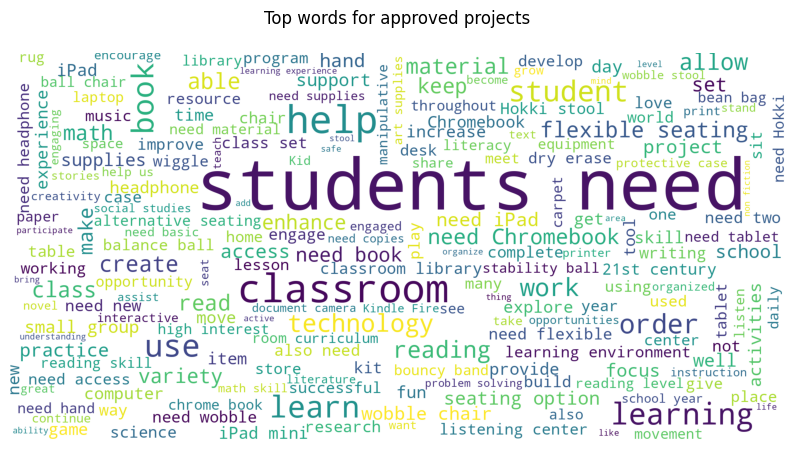

In [126]:
from wordcloud import WordCloud
word_cloud_for_project_resource_summary = ' '.join(train_data_merged.loc[train_data_merged['project_is_approved'] == 1, 'project_resource_summary'].values)
wordcloud = WordCloud(max_font_size=None, stopwords=stopwords, background_color='white',
                      width=2000, height=1000).generate(word_cloud_for_project_resource_summary)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)
plt.title('Top words for approved projects'+'\n')
plt.axis("off")
plt.show()

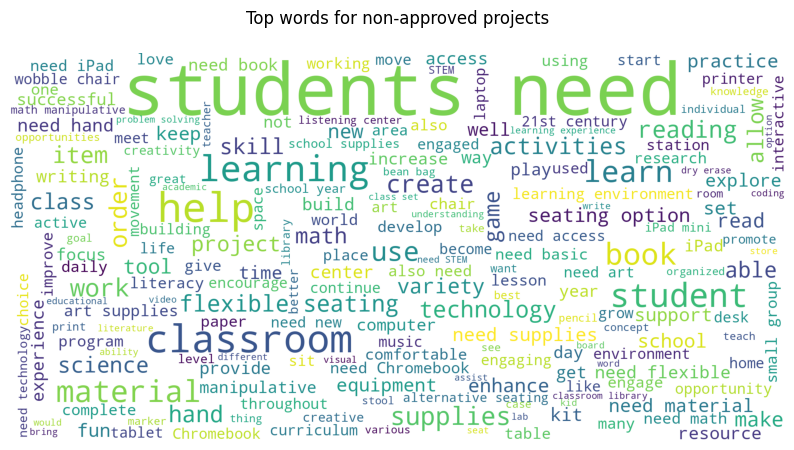

In [127]:
word_cloud_for_project_resource_summary = ' '.join(train_data_merged.loc[train_data_merged['project_is_approved'] == 0, 'project_resource_summary'].values)
wordcloud = WordCloud(max_font_size=None, stopwords=stopwords, background_color='white',
                      width=2000, height=1000).generate(word_cloud_for_project_resource_summary)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)
plt.title('Top words for non-approved projects'+'\n')
plt.axis("off")
plt.show()


Based on wordcloud observations, it appears no difference with words used in approved and non-approved summaries. Hence proceeding to drop the column project_resource_summary

In [128]:
cols_to_drop_from = [
    'id',
    'teacher_id',
    'project_submitted_datetime',
    'project_resource_summary',
    'Unnamed: 0'
]

dc_train_data_merged = train_data_merged.drop(cols_to_drop_from, axis=1)

print('after dropping ', dc_train_data_merged.columns)

after dropping  Index(['teacher_prefix', 'school_state', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'project_essay', 'dc_res_cost'],
      dtype='object')


In [129]:
dc_train_data_merged.head()

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,teacher_number_of_previously_posted_projects,project_is_approved,project_essay,dc_res_cost
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,educational support english learners home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,0,0,students english learners working english seco...,3555.80
1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,wanted projector hungry learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,7,1,students arrive school eager learn polite gene...,299.00
2,ms,az,grades_6_8,health_sports,health_wellness_teamsports,soccer equipment awesome middle school students,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,1,0,true champions not always ones win guts mia ha...,11370.70
3,mrs,ky,grades_prek_2,literacy_language_math_science,literacy_mathematics,techie kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,4,1,work unique school filled esl english second l...,931.60
4,mrs,tx,grades_prek_2,math_science,mathematics,interactive math tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,1,1,second grade classroom next year made around 2...,271.92


# Split the train data into train and validation set

In [130]:
y_dc_train_data_merged = dc_train_data_merged['project_is_approved'].values
x_dc_train_data_merged = dc_train_data_merged.drop(['project_is_approved'], axis=1)

X_dc_train, X_dc_validation, y_dc_train, y_dc_validation = train_test_split(x_dc_train_data_merged, y_dc_train_data_merged, test_size=0.20,random_state=42)
print(x_dc_train_data_merged.shape)

X_dc_train.head()

(109248, 13)


,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,teacher_number_of_previously_posted_projects,project_essay,dc_res_cost
23690,mrs,ny,grades_prek_2,health_sports,health_wellness,fun seats promote fitness first grade,My students are an amazing group of first grad...,My first graders asked for some comfy seats th...,NaN,NaN,2,students amazing group first graders come dive...,349.75
32874,mrs,md,grades_prek_2,health_sports,health_wellness,minds bodies motion aim target excel,My second grade student's are full of energy a...,After reading an article on Movement and how i...,NaN,NaN,2,second grade student full energy eager learn w...,1186.68
50206,ms,ok,grades_prek_2,math_science,mathematics,gobble gobble let wobble,"We, second graders, are pretty spectacular. We...",Our wobble chairs will provide great opportuni...,NaN,NaN,0,second graders pretty spectacular part communi...,257.84
47892,ms,ma,grades_3_5,literacy_language_math_science,literature_writing_mathematics,laptops learning,I have a class full of scholars who are ready ...,I am asking for 10 Chromebook laptops. I feel ...,NaN,NaN,4,class full scholars ready take 4th grade make ...,3578.00
10398,mrs,ca,grades_6_8,history_civics_literacy_language,history_geography_literacy,witches colonial new england newbery medal awa...,My school is fantastically unique. We exempli...,"I am bringing the \""book club\"" to our classro...",NaN,NaN,14,school fantastically unique exemplify benefits...,2343.00


In [131]:
x_dc_train_data_merged.columns


Index(['teacher_prefix', 'school_state', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4',
       'teacher_number_of_previously_posted_projects', 'project_essay',
       'dc_res_cost'],
      dtype='object')

# Converting text to a matrix of TF-IDF Features. Equivalent to CountVectorizer followed by TfidfTransformer

TF-IDF (Term Frequency — Inverse Document Frequency) is a metric that reflects how important a word is to a particular document in a corpus of documents.
In short, the more a word appears in a given document and the less it appears overall in an entire collection of documents the higher the TF-IDF score, and therefore the higher the relevancy. Because of this it is often used as a weighting score for information retrieval, when a user gives a list of keywords we can calculate the TF-IDF score for each phrase and for each document and the highest scoring document is the most relevant to the user’s search.

In [ ]:
vectorizer_on_features = CountVectorizer(lowercase=False, binary=True)

In [132]:
tfidf_vectorizer_on_features = TfidfVectorizer(lowercase=False, binary=True)

In [133]:
dc_train_vectorized_subj_cat = tfidf_vectorizer_on_features.fit_transform(X_dc_train['project_subject_categories'].values)
print(dc_train_vectorized_subj_cat.shape)

dc_validation_vectorized_subj_cat = tfidf_vectorizer_on_features.transform(X_dc_validation['project_subject_categories'].values)
print(dc_validation_vectorized_subj_cat.shape)



(87398, 51)
(21850, 51)


In [134]:
dc_train_vectorized_subj_subcat = tfidf_vectorizer_on_features.fit_transform(X_dc_train['project_subject_subcategories'].values)
print(dc_train_vectorized_subj_cat.shape)

dc_validation_vectorized_subj_subcat = tfidf_vectorizer_on_features.transform(X_dc_validation['project_subject_subcategories'].values)
print(dc_validation_vectorized_subj_cat.shape)

(87398, 51)
(21850, 51)


In [135]:
dc_train_vectorized_teacher_prefix = tfidf_vectorizer_on_features.fit_transform(X_dc_train['teacher_prefix'].values)
print(dc_train_vectorized_teacher_prefix.shape)

dc_validation_vectorized_teacher_prefix = tfidf_vectorizer_on_features.transform(X_dc_validation['teacher_prefix'].values)
print(dc_validation_vectorized_teacher_prefix.shape)

(87398, 5)
(21850, 5)


In [136]:
dc_train_vectorized_grade_cat = tfidf_vectorizer_on_features.fit_transform(X_dc_train['project_grade_category'].values)
print(dc_train_vectorized_grade_cat.shape)

dc_validation_vectorized_grade_cat = tfidf_vectorizer_on_features.transform(X_dc_validation['project_grade_category'].values)
print(dc_validation_vectorized_grade_cat.shape)

(87398, 4)
(21850, 4)


In [137]:
dc_train_vectorized_sch_state = tfidf_vectorizer_on_features.fit_transform(X_dc_train['school_state'].values)
print(dc_train_vectorized_sch_state.shape)

dc_validation_vectorized_sch_state = tfidf_vectorizer_on_features.transform(X_dc_validation['school_state'].values)
print(dc_validation_vectorized_sch_state.shape)


(87398, 51)
(21850, 51)


# Normalizing Numerical values on cost and number of prior posted projects

NOTE: specify the correct shape parameter for the norm.fit_transform method. Since the input data is a 2D array, you should use the shape parameter (1, -1) to indicate that the first dimension is fixed to 1 and the second dimension is unknown.

In [138]:
norm = Normalizer()

In [139]:
norm.fit(X_dc_train['dc_res_cost'].values.reshape(1,-1))
dc_train_normed_cost = norm.transform(X_dc_train['dc_res_cost'].values.reshape(1,-1))
print(dc_train_normed_cost.reshape(-1,1).shape)

dc_validation_normed_cost = norm.fit_transform(X_dc_validation['dc_res_cost'].values.reshape(1,-1))
dc_validation_normed_cost.reshape(-1,1).shape

(87398, 1)


(21850, 1)

In [140]:
norm.fit(X_dc_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

dc_train_normed_teacher_num_ppprojects = norm.transform(X_dc_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
print(dc_train_normed_teacher_num_ppprojects.reshape(-1,1).shape)

dc_validation_normed_teacher_num_ppprojects = norm.fit_transform(X_dc_validation['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
dc_validation_normed_teacher_num_ppprojects.reshape(-1,1).shape

(87398, 1)


(21850, 1)

# Encoding project_essay with Bag of words (BOW)

In [141]:
# When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold (cut-off), in this case set to 10.
vectorized_proj_essay_bow = TfidfVectorizer(min_df=10)

dc_train_vectorized_proj_essay = vectorized_proj_essay_bow.fit_transform(X_dc_train['project_essay'])
print(dc_train_vectorized_proj_essay.shape)

dc_validation_vectorized_proj_essay = vectorized_proj_essay_bow.transform(X_dc_validation['project_essay'])
print(dc_validation_vectorized_proj_essay.shape)

(87398, 15143)
(21850, 15143)


# Stack sparse matrices horizontally (column wise)

In [142]:
dc_train_hstacked_all_features_vectorized = hstack((dc_train_vectorized_subj_cat,dc_train_vectorized_subj_subcat,dc_train_vectorized_teacher_prefix,dc_train_vectorized_grade_cat,dc_train_vectorized_sch_state,dc_train_normed_cost.reshape(-1,1),dc_train_normed_teacher_num_ppprojects.reshape(-1,1),dc_train_vectorized_proj_essay))
print(dc_train_hstacked_all_features_vectorized.shape)

dc_validation_hstacked_all_features_vectorized = hstack((dc_validation_vectorized_subj_cat,dc_validation_vectorized_subj_subcat,dc_validation_vectorized_teacher_prefix,dc_validation_vectorized_grade_cat,dc_validation_vectorized_sch_state,dc_validation_normed_cost.reshape(-1,1),dc_validation_normed_teacher_num_ppprojects.reshape(-1,1),dc_validation_vectorized_proj_essay))
print(dc_validation_hstacked_all_features_vectorized.shape)

(87398, 15651)
(21850, 15651)


# Selecting multinomial Naive Bayes classifier for classification with discrete features (that is, for word counts for text classification).

In [155]:
multinomial_nb_bow = MultinomialNB(class_prior = [0.3,0.7], fit_prior = False)
multinomial_nb_bow.get_params()


{'alpha': 1.0,
 'class_prior': [0.3, 0.7],
 'fit_prior': False,
 'force_alpha': 'warn'}

# Hyper parameter tuning with GridSearchCV

In [160]:
parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}
#scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

clf = GridSearchCV(multinomial_nb_bow, parameters, cv=10, scoring="roc_auc_ovo", return_train_score=True, refit=True)

clf.fit(dc_train_hstacked_all_features_vectorized,y_dc_train)


best_alpha_1_bow = clf.best_params_['alpha']
best_score_1_bow = clf.best_score_

print('Best Alpha BOW: ', best_alpha_1_bow )
print('Best Score BOW : ', best_score_1_bow)

train_auc_bow = clf.cv_results_['mean_train_score']
train_auc_std_bow = clf.cv_results_['std_train_score']
cv_auc_bow = clf.cv_results_['mean_test_score']
cv_auc_std_bow = clf.cv_results_['std_test_score']


Best Alpha BOW:  0.05
Best Score BOW :  0.6700235123505837


100%|██████████| 20/20 [00:00<00:00, 20769.02it/s]


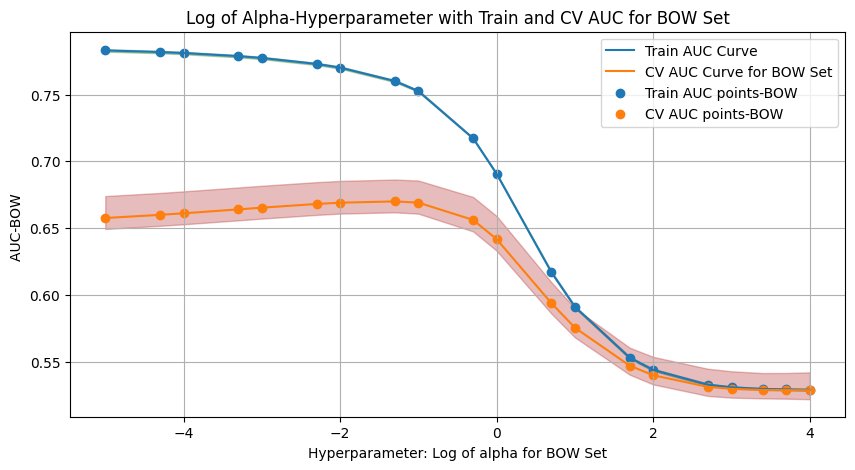

In [161]:
alphas = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]
log_of_alphas = []

for alpha in tqdm(alphas):
  alpha_log = np.log10(alpha)
  log_of_alphas.append(alpha_log)

plt.figure(figsize=(10, 5))
plt.plot(log_of_alphas, train_auc_bow, label='Train AUC Curve' )

plt.gca().fill_between(log_of_alphas, train_auc_bow - train_auc_std_bow, train_auc_bow + train_auc_std_bow, alpha=0.3, color='darkgreen' )
plt.plot(log_of_alphas, cv_auc_bow, label='CV AUC Curve for BOW Set' )
plt.gca().fill_between(log_of_alphas, cv_auc_bow - cv_auc_std_bow, cv_auc_bow+cv_auc_std_bow + cv_auc_std_bow, alpha=0.3, color='firebrick' )

plt.scatter(log_of_alphas, train_auc_bow, label='Train AUC points-BOW' )
plt.scatter(log_of_alphas, cv_auc_bow, label='CV AUC points-BOW' )

plt.legend()
plt.xlabel('Hyperparameter: Log of alpha for BOW Set')
plt.ylabel('AUC-BOW ')
plt.title('Log of Alpha-Hyperparameter with Train and CV AUC for BOW Set')
plt.grid()
plt.show()





In [162]:

naive_bayes_results_for_bow_with_best_alpha = MultinomialNB(alpha = best_alpha_1_bow, class_prior=[0.3, 0.7], fit_prior=False )

naive_bayes_results_for_bow_with_best_alpha.fit(dc_train_hstacked_all_features_vectorized,y_dc_train)
y_predicted_for_bow_with_best_alpha_train = naive_bayes_results_for_bow_with_best_alpha.predict_proba(dc_train_hstacked_all_features_vectorized)[:, 1]
print('y_predicted_for_bow_with_best_alpha_train.shape is ' , y_predicted_for_bow_with_best_alpha_train.shape)
y_predicted_for_bow_with_best_alpha_validation = naive_bayes_results_for_bow_with_best_alpha.predict_proba(dc_validation_hstacked_all_features_vectorized)[:, 1]
print('y_predicted_for_bow_with_best_alpha_validation.shape is', y_predicted_for_bow_with_best_alpha_validation.shape)

y_predicted_for_bow_with_best_alpha_train.shape is  (87398,)
y_predicted_for_bow_with_best_alpha_validation.shape is (21850,)


fpr_train_bow:  [0.         0.         0.         ... 0.99939513 0.99939513 1.        ]
tpr_train_bow:  [0.00000000e+00 1.34821766e-05 3.37054414e-03 ... 9.99986518e-01
 1.00000000e+00 1.00000000e+00]
thresholds_train_bow:  [1.99784852e+00 9.97848518e-01 9.73144885e-01 ... 4.93680386e-02
 4.64423538e-02 9.46320797e-05]
fpr_validation_bow:  [0.         0.         0.         ... 0.99939513 0.99939513 1.        ]
tpr_validation_bow:  [0.00000000e+00 5.39548937e-05 1.07909787e-04 ... 9.99946045e-01
 9.99946045e-01 1.00000000e+00]
thresholds_validation_bow:  [1.99798806 0.99798806 0.99758119 ... 0.07352125 0.03473058 0.03080054]


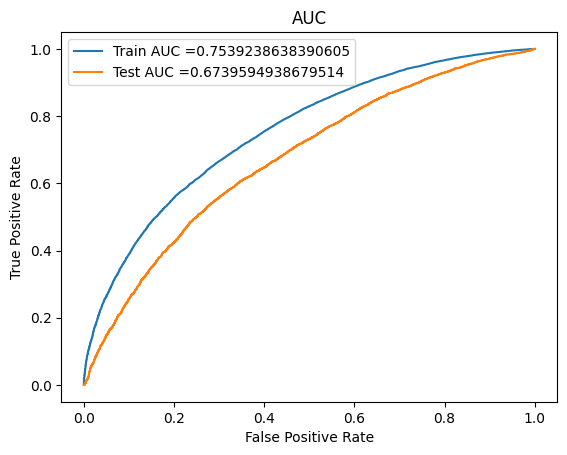

In [163]:
fpr_train_bow, tpr_train_bow, thresholds_train_bow = roc_curve(y_dc_train, y_predicted_for_bow_with_best_alpha_train )
fpr_validation_bow, tpr_validation_bow, thresholds_validation_bow = roc_curve(y_dc_validation, y_predicted_for_bow_with_best_alpha_validation )

print('fpr_train_bow: ', fpr_train_bow)
print('tpr_train_bow: ', tpr_train_bow)
print('thresholds_train_bow: ', thresholds_train_bow)
print('fpr_validation_bow: ', fpr_train_bow)
print('tpr_validation_bow: ', tpr_validation_bow)
print('thresholds_validation_bow: ', thresholds_validation_bow)

ax = plt.subplot()

auc_bow_train = auc(fpr_train_bow, tpr_train_bow)
auc_bow_validation = auc(fpr_validation_bow, tpr_validation_bow)

ax.plot(fpr_train_bow, tpr_train_bow, label='Train AUC ='+str(auc(fpr_train_bow, tpr_train_bow)))
ax.plot(fpr_validation_bow, tpr_validation_bow, label='Test AUC ='+str(auc(fpr_validation_bow, tpr_validation_bow)))

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC')
ax.set_facecolor('white')
plt.show()